Colab Specific

In [1]:
# from google.colab import data_table
# data_table.enable_dataframe_formatter()

In [1]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-dark')
plt.rc('figure', figsize=(10, 7))
plt.rc('font', size=12)

# Data Information

https://www.kaggle.com/simiotic/ethereum-nfts

# Analysing NFT Database

In [2]:
import sqlite3
import pandas as pd
import numpy as np

In [4]:
from nft_analyser.helper import conn
# conn = sqlite3.connect('data/nfts.sqlite')

In [5]:
db_schema_df = pd.read_sql_query("SELECT * from sqlite_master WHERE type='table'", conn)
db_schema_df['name'].values

array(['nfts', 'checkpoint', 'mints', 'transfers',
       'transfer_values_quartile_10_distribution_per_address',
       'current_owners', 'current_market_values',
       'market_values_distribution', 'transfer_statistics_by_address',
       'transfer_values_quantile_10_distribution_per_address',
       'transfer_values_quantile_25_distribution_per_address',
       'transfers_mints', 'mint_holding_times', 'transfer_holding_times',
       'ownership_transitions'], dtype=object)

In [6]:
# Helper Functions
eth_usd = 3000    # Min value asof 8th Jan 2022

def show(table, count=100, conn=conn):
  return pd.read_sql_query(f'SELECT * FROM {table} LIMIT {count}', conn)

## Description of different features

* **nft_address** - Address of the smart contract
* **token_id** - Identifier of a NFT within a nft_address. That means, a given nft_address (i.e. smart contract) can contain multiple NFTs which are represented by token_id

## Quick Analysis of Relevant Tables

### current_market_values

In [7]:
show('current_market_values').head(3)

,nft_address,token_id,market_value
0,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,0,30000000000000000
1,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,1,150000000000000000
2,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,10,150000000000000000


In [8]:
df = pd.read_sql_query(
    f"""SELECT market_value*{eth_usd}/1e18 AS value_usd 
    FROM current_market_values 
    WHERE value_usd > 1""",
    conn)

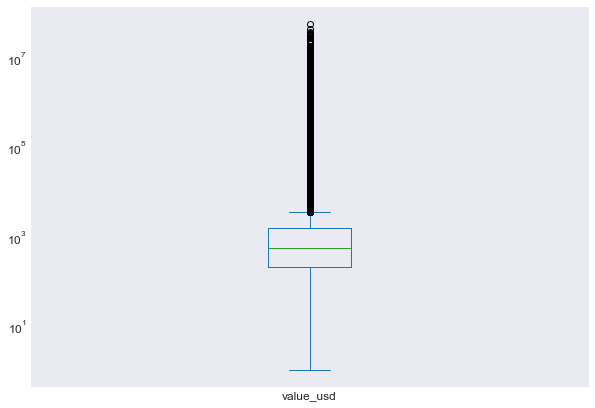

In [9]:
df.plot(kind='box', logy=True);

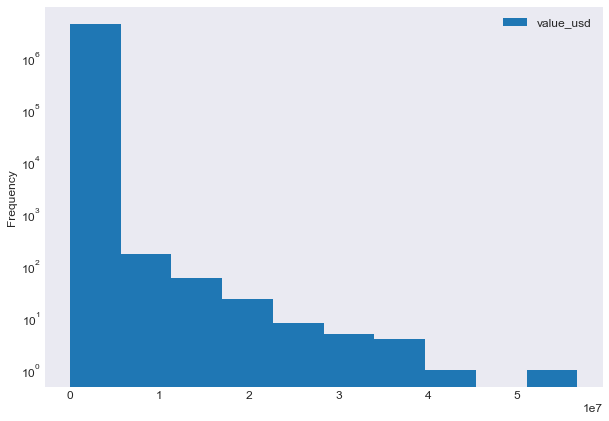

In [49]:
df.plot(kind='hist', logy=True);

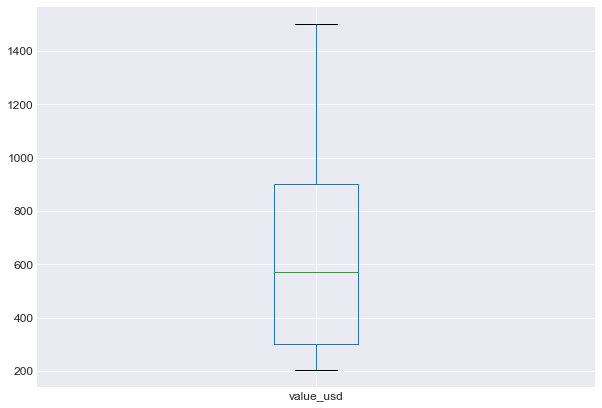

In [45]:
qtiles = [v[0] for v in df.quantile(q=[0.25, 0.75]).values]
df[(df.value_usd >= qtiles[0]) & (df.value_usd <= qtiles[1])].boxplot();

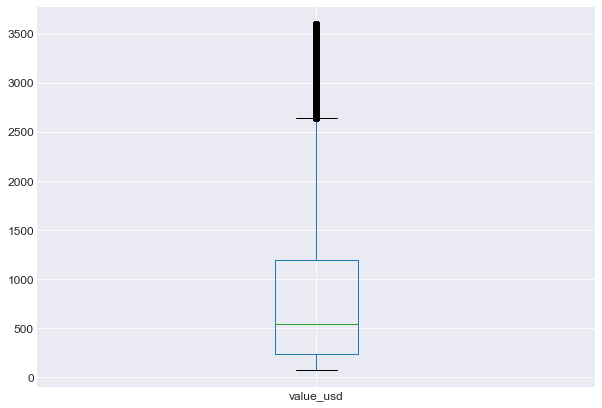

In [46]:
qtiles = [v[0] for v in df.quantile(q=[0.1, 0.9]).values]
df[(df.value_usd >= qtiles[0]) & (df.value_usd <= qtiles[1])].boxplot();

### current_owners

TODO:
* Combine _current_market_values_ with _current_owners_ to find the estimated wealth by players of NFT market. Inference could be, low barrier to entry.
* Try to see if players belonging to this category were able to sell their NFT for profit

In [51]:
show('current_owners').head(3)

,nft_address,token_id,owner
0,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,0,0xb776cAb26B9e6Be821842DC0cc0e8217489a4581
1,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,1,0x8A73024B39A4477a5Dc43fD6360e446851AD1D28
2,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,10,0x5e5C817E9264B46cBBB980198684Ad9d14f3e0B4


In [52]:
df = pd.read_sql_query(
    f"""SELECT owner, count(nft_address) AS num_nfts
    FROM current_owners
    GROUP BY owner""",
    conn)

In [53]:
df['num_nfts']

0         83548
1          5531
2             1
3             1
4             1
          ...  
625349       44
625350        9
625351        2
625352        1
625353        6
Name: num_nfts, Length: 625354, dtype: int64

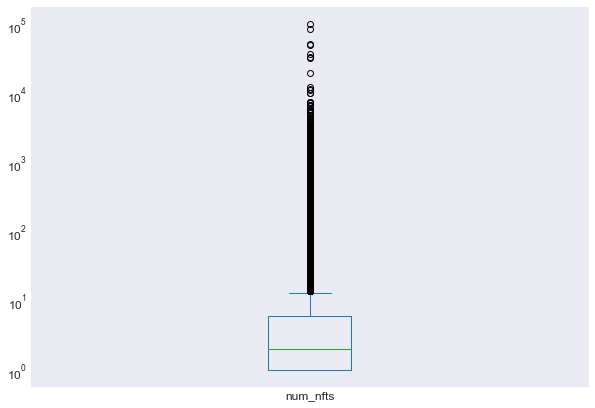

In [13]:
df['num_nfts'].plot(kind='box', logy=True);

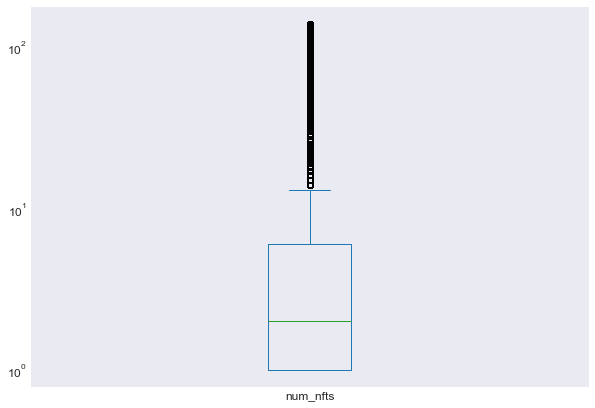

In [71]:
qtiles = [v[0] for v in df.quantile(q=[0.0, 0.99]).values]
df[(df.num_nfts >= qtiles[0]) & (df.num_nfts <= qtiles[1])].plot(kind='box', logy=True);

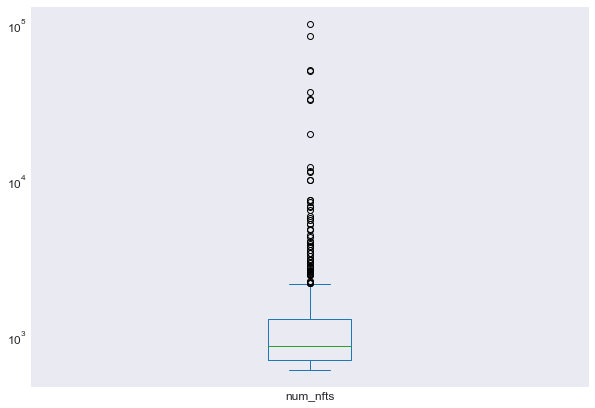

In [72]:
qtiles = [v[0] for v in df.quantile(q=[0.999, 1]).values]
df[(df.num_nfts >= qtiles[0]) & (df.num_nfts <= qtiles[1])].plot(kind='box', logy=True);

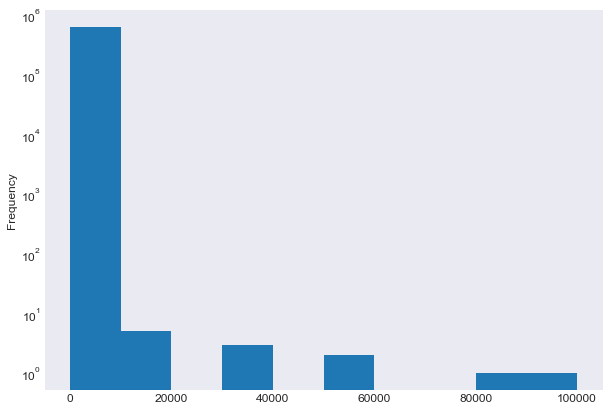

In [55]:
df['num_nfts'].plot(kind='hist', logy=True);

### mint_holding_times

In [73]:
show('mint_holding_times').head(3)

,days,num_holds
0,0,1178780
1,1,235589
2,2,143971


In [105]:
df = pd.read_sql_query("SELECT * FROM mint_holding_times", conn).set_index('days')

In [122]:
total_nfts = df['num_holds'].sum()
percentages = [50, 75, 90, 95, 99]
num_days = [(cum_df - total_nfts*p/100).abs().sort_values(by='num_holds').index[0] for p in percentages]
num_days

[0, 6, 23, 42, 98]

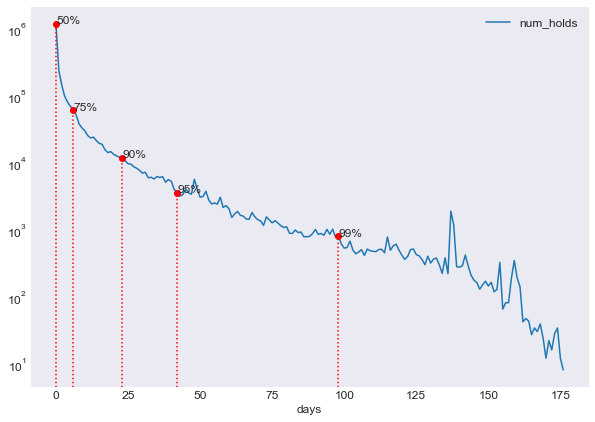

In [136]:
fig = plt.figure()
ax = fig.gca()
df.plot(logy=True, ax=ax)
ax.stem(num_days, df.loc[num_days].values, linefmt='r:', markerfmt='ro')
for p, x, y in zip(percentages, num_days, df.loc[num_days].values):
    ax.text(x, y, f'{p}%')

### nfts

TODO:
* Do analysis of which words are more likely to sell (word2vec for both name and symbol)

In [19]:
show('nfts').head(3)

,address,name,symbol
0,0xF4ee95274741437636e748DdAc70818B4ED7d043,The Doge Pound,DOGGY
1,0xba30E5F9Bb24caa003E9f2f0497Ad287FDF95623,BoredApeKennelClub,BAKC
2,0x7403AC30DE7309a0bF019cdA8EeC034a5507cbB3,Characters,CHAR
